# Importing Libraries

In [1]:
import numpy as np, pandas as pd
import json
import ast 
from textblob import TextBlob
import nltk
import torch
import pickle
from scipy import spatial
import warnings
warnings.filterwarnings('ignore')
import spacy
from nltk import Tree
from nltk.stem.lancaster import LancasterStemmer
st = LancasterStemmer()
from sklearn.feature_extraction.text import TfidfVectorizer, TfidfTransformer
en_nlp = spacy.load('en')

# Convert JSON to Pandas Dataframe

In [2]:
train = pd.read_json("data/train-v1.1.json") #Read the train data JSON File
valid = pd.read_json("data/dev-v1.1.json") #Read the valid data JSON File

In [3]:
train.shape, valid.shape

((442, 2), (48, 2))

In [4]:
train.iloc[1,0]['paragraphs'][0]

{'context': 'Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ bee-YON-say) (born September 4, 1981) is an American singer, songwriter, record producer and actress. Born and raised in Houston, Texas, she performed in various singing and dancing competitions as a child, and rose to fame in the late 1990s as lead singer of R&B girl-group Destiny\'s Child. Managed by her father, Mathew Knowles, the group became one of the world\'s best-selling girl groups of all time. Their hiatus saw the release of Beyoncé\'s debut album, Dangerously in Love (2003), which established her as a solo artist worldwide, earned five Grammy Awards and featured the Billboard Hot 100 number-one singles "Crazy in Love" and "Baby Boy".',
 'qas': [{'answers': [{'answer_start': 269, 'text': 'in the late 1990s'}],
   'question': 'When did Beyonce start becoming popular?',
   'id': '56be85543aeaaa14008c9063'},
  {'answers': [{'answer_start': 207, 'text': 'singing and dancing'}],
   'question': 'What areas did Beyonce compet

In [5]:
from models import InferSent
V = 2
MODEL_PATH = '/Users/devshreepatel/Desktop/LR/encoder/infersent%s.pkl' % V
params_model = {'bsize': 64, 'word_emb_dim': 300, 'enc_lstm_dim': 2048,
                'pool_type': 'max', 'dpout_model': 0.0, 'version': V} # Model Parameters For Infersent Model
infersent = InferSent(params_model) # Infersent Pre Trained encoder by Facebook
infersent.load_state_dict(torch.load(MODEL_PATH)) # Load Dictionary

<All keys matched successfully>

In [6]:
contexts = []       
questions = []
answers_text = []
answers_start = []
for i in range(train.shape[0]):
    topic = train.iloc[i,0]['paragraphs'] # To select each paragraph from data and gather corresponding info of it.
    for sub_para in topic:
        for q_a in sub_para['qas']:
            questions.append(q_a['question']) # To get Question of each paragraph 
            answers_start.append(q_a['answers'][0]['answer_start']) # To get the start index of answer
            answers_text.append(q_a['answers'][0]['text']) # To get the Answer for the question
            contexts.append(sub_para['context']) # To get the context of the paragraph
df = pd.DataFrame({"context":contexts, "question": questions, "answer_start": answers_start, "text": answers_text})

In [7]:
df.shape

(87599, 4)

In [8]:
df.to_csv("data/train.csv", index = None) # Change JSON file to CSV file

## Create dictionary of sentence embeddings for faster computation

In [9]:
paras = list(df["context"].drop_duplicates().reset_index(drop= True)) # Create List of all Contexts and drop duplicates

In [10]:
len(paras)

18891

In [11]:
blob = TextBlob(" ".join(paras)) 
sentences = [item.raw for item in blob.sentences]

In [12]:
len(sentences)

92659

In [13]:
W2V_PATH = '/Users/devshreepatel/Desktop/LR/data/fastText/crawl-300d-2M.vec'
infersent.set_w2v_path(W2V_PATH) # Set the Word To Vector Path for embeddings

In [14]:
infersent.build_vocab(sentences, tokenize=True) # Using Function of InferSent Class to build vocabulary

Found 89231(/109703) words with w2v vectors
Vocab size : 89231


## Generating word embeddings

In [15]:
dict_embeddings = {}
for i in range(len(sentences)):
    print(i)
    dict_embeddings[sentences[i]] = infersent.encode([sentences[i]], tokenize=True) # Encode the sentences in dict_embeddings

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139


KeyboardInterrupt: 

In [16]:
questions = list(df["question"]) #Use the question column from df and create a list

In [17]:
len(questions)

87599

In [18]:
for i in range(len(questions)):
    print(i)
    dict_embeddings[questions[i]] = infersent.encode([questions[i]], tokenize=True) # Generate encoding for questions

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184


KeyboardInterrupt: 

# Create dictionary with each Sentence and corresponding word embeddings array 

In [19]:
d1 = {key:dict_embeddings[key] for i, key in enumerate(dict_embeddings) if i % 2 == 0} 
d2 = {key:dict_embeddings[key] for i, key in enumerate(dict_embeddings) if i % 2 == 1}

In [20]:
d1

{'Architecturally, the school has a Catholic character.': array([[ 0.00746889, -0.05086312,  0.00736476, ...,  0.04118386,
          0.01421822, -0.0138564 ]], dtype=float32),
 'Immediately in front of the Main Building and facing it, is a copper statue of Christ with arms upraised with the legend "Venite Ad Me Omnes".': array([[0.00746889, 0.00995223, 0.19095321, ..., 0.00119955, 0.04134529,
         0.03366187]], dtype=float32),
 'Immediately behind the basilica is the Grotto, a Marian place of prayer and reflection.': array([[ 0.00746889, -0.0568299 ,  0.11969507, ..., -0.01752903,
          0.01482134, -0.00012652]], dtype=float32),
 'At the end of the main drive (and in a direct line that connects through 3 statues and the Gold Dome), is a simple, modern stone statue of Mary.': array([[ 0.00746889, -0.01367914,  0.1417282 , ...,  0.00988861,
         -0.00070966,  0.06526423]], dtype=float32),
 'The nine student-run outlets include three newspapers, both a radio and television sta

In [21]:
d2

{"Atop the Main Building's gold dome is a golden statue of the Virgin Mary.": array([[ 0.00746889, -0.02137874,  0.17287011, ...,  0.00844874,
          0.04903353,  0.04396459]], dtype=float32),
 'Next to the Main Building is the Basilica of the Sacred Heart.': array([[ 0.00746889, -0.02694481,  0.16048309, ..., -0.03994385,
         -0.00807925, -0.00656207]], dtype=float32),
 'It is a replica of the grotto at Lourdes, France where the Virgin Mary reputedly appeared to Saint Bernadette Soubirous in 1858.': array([[ 0.00746889, -0.04131714,  0.10167662, ...,  0.05108181,
          0.04168973,  0.01518794]], dtype=float32),
 "As at most other universities, Notre Dame's students run a number of news media outlets.": array([[ 0.00746889, -0.03765845,  0.03816633, ...,  0.05854929,
          0.02586767, -0.01350585]], dtype=float32),
 'Begun as a one-page journal in September 1876, the Scholastic magazine is issued twice monthly and claims to be the oldest continuous collegiate publicatio

In [22]:
# Open the file and dump the word embeddings in d1 in file
with open('data/dict_embeddings1.pickle', 'wb') as handle:
    pickle.dump(d1, handle)

In [23]:
# Open the file and dump the word embeddings in d2 in file
with open('data/dict_embeddings2.pickle', 'wb') as handle:
    pickle.dump(d2, handle)

In [24]:
del dict_embeddings

In [25]:
from sklearn import linear_model
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler

In [26]:
train = pd.read_csv("data/train.csv") # Load the train data CSV file

In [27]:
train.shape

(87599, 4)

### Loading Embedding dictionary

In [28]:
# Open the pickle file 1 with word embeddings and load to d1
with open("data/dict_1.pickle", "rb") as f:
    d1 = pickle.load(f)

In [29]:
# Open the pickle file 2 with word embeddings and load to d2
with open("data/dict_2.pickle", "rb") as f:
    d2 = pickle.load(f)

In [30]:
# Concatenate the two dictionaries with word embeddings in one dict_emb
dict_emb = dict(d1)
dict_emb.update(d2)

In [31]:
len(dict_emb)

179862

In [32]:
del d1, d2

## Data Pre-Processing

In [33]:
# This function sets the value of column Target which is the sentence number in the paragraph which contains the answer.
def get_target(x):
    idx = -1
    for i in range(len(x["sentences"])):
        if x["text"] in x["sentences"][i]: idx = i
    return idx

In [34]:
train.head(3)

,context,question,answer_start,text
0,"Architecturally, the school has a Catholic cha...",To whom did the Virgin Mary allegedly appear i...,515,Saint Bernadette Soubirous
1,"Architecturally, the school has a Catholic cha...",What is in front of the Notre Dame Main Building?,188,a copper statue of Christ
2,"Architecturally, the school has a Catholic cha...",The Basilica of the Sacred heart at Notre Dame...,279,the Main Building


In [35]:
train.shape

(87599, 4)

In [36]:
# Use of dropna function to drop null values using inplace=True to make the changes in CSV file automatic 
train.dropna(inplace=True)

## Processing Data

In [37]:
# This function to add the extra columns to the training data: sentences, target, sent_emb, quest_emb
def process_data(train):
    
    print("step 1")
    train['sentences'] = train['context'].apply(lambda x: [item.raw for item in TextBlob(x).sentences])
    
    print("step 2")
    train["target"] = train.apply(get_target, axis = 1)
    
    print("step 3")
    train['sent_emb'] = train['sentences'].apply(lambda x: [dict_emb[item][0] if item in
                                                           dict_emb else np.zeros(4096) for item in x])
    print("step 4")
    train['quest_emb'] = train['question'].apply(lambda x: dict_emb[x] if x in dict_emb else np.zeros(4096) )
        
    return train   

In [38]:
# Run this to process data to add columns 
train = process_data(train)

step 1
step 2
step 3
step 4


In [39]:
train.shape

(87598, 8)

In [40]:
train.head(3)

,context,question,answer_start,text,sentences,target,sent_emb,quest_emb
0,"Architecturally, the school has a Catholic cha...",To whom did the Virgin Mary allegedly appear i...,515,Saint Bernadette Soubirous,"[Architecturally, the school has a Catholic ch...",5,"[[0.0074688885, -0.050863117, 0.007364763, -0....","[[0.0074688885, 0.024210272, 0.069616325, -0.0..."
1,"Architecturally, the school has a Catholic cha...",What is in front of the Notre Dame Main Building?,188,a copper statue of Christ,"[Architecturally, the school has a Catholic ch...",2,"[[0.0074688885, -0.050863117, 0.007364763, -0....","[[0.0074688885, -0.033483382, 0.040545918, -0...."
2,"Architecturally, the school has a Catholic cha...",The Basilica of the Sacred heart at Notre Dame...,279,the Main Building,"[Architecturally, the school has a Catholic ch...",3,"[[0.0074688885, -0.050863117, 0.007364763, -0....","[[0.0074688885, -0.043944724, 0.14385942, -0.0..."


## Predicted Cosine & Euclidean Index

In [41]:
#Find the Cosine similarity Between Question and Answer 
def cosine_sim(x):
    li = []
    for item in x["sent_emb"]:
        li.append(spatial.distance.cosine(item,x["quest_emb"][0]))
    return li   

In [42]:
#This function is to find the argmin between all the distances of a single sentence array to find the predicted target ...
#sentence number
def pred_idx(distances):
    return np.argmin(distances)

In [43]:
# The euclidean distance and cosine similarity are calculated and predictions are made using above function and stored 
def predictions(train):
    
    train["cosine_sim"] = train.apply(cosine_sim, axis = 1)
    train["diff"] = (train["quest_emb"] - train["sent_emb"])**2
    train["euclidean_dis"] = train["diff"].apply(lambda x: list(np.sum(x, axis = 1)))
    del train["diff"]
    
    print("cosine start")
    
    train["pred_idx_cos"] = train["cosine_sim"].apply(lambda x: pred_idx(x))
    train["pred_idx_euc"] = train["euclidean_dis"].apply(lambda x: pred_idx(x))
    
    return train

In [44]:
#Call to make the predictions
predicted = predictions(train)

cosine start


In [45]:
predicted.shape

(87598, 12)

In [46]:
predicted.head(3)

,context,question,answer_start,text,sentences,target,sent_emb,quest_emb,cosine_sim,euclidean_dis,pred_idx_cos,pred_idx_euc
0,"Architecturally, the school has a Catholic cha...",To whom did the Virgin Mary allegedly appear i...,515,Saint Bernadette Soubirous,"[Architecturally, the school has a Catholic ch...",5,"[[0.0074688885, -0.050863117, 0.007364763, -0....","[[0.0074688885, 0.024210272, 0.069616325, -0.0...","[0.6835565567016602, 0.5527453124523163, 0.574...","[7.301305, 6.4764132, 7.214262, 6.9176197, 6.5...",5,5
1,"Architecturally, the school has a Catholic cha...",What is in front of the Notre Dame Main Building?,188,a copper statue of Christ,"[Architecturally, the school has a Catholic ch...",2,"[[0.0074688885, -0.050863117, 0.007364763, -0....","[[0.0074688885, -0.033483382, 0.040545918, -0....","[0.6624992787837982, 0.5191770792007446, 0.592...","[5.717004, 5.076439, 6.3408985, 3.5867877, 4.8...",3,3
2,"Architecturally, the school has a Catholic cha...",The Basilica of the Sacred heart at Notre Dame...,279,the Main Building,"[Architecturally, the school has a Catholic ch...",3,"[[0.0074688885, -0.050863117, 0.007364763, -0....","[[0.0074688885, -0.043944724, 0.14385942, -0.0...","[0.6164608299732208, 0.4940056800842285, 0.521...","[5.3495297, 4.8541417, 5.6286764, 2.8828857, 3...",3,3


In [47]:
predicted["cosine_sim"][0]

[0.6835565567016602,
 0.5527453124523163,
 0.5747938454151154,
 0.624308854341507,
 0.619026243686676,
 0.25835102796554565,
 0.5743658542633057]

In [48]:
predicted["euclidean_dis"][0]

[7.301305, 6.4764132, 7.214262, 6.9176197, 6.519748, 3.6410067, 6.9080434]

## Accuracy

In [49]:
# Calculate the accuracy between predicted and target values
def accuracy(target, predicted):
    acc = (target==predicted).sum()/len(target)
    return acc

### Accuracy for  euclidean Distance

In [50]:
print(accuracy(predicted["target"], predicted["pred_idx_euc"]))

0.488778282609192


### Accuracy for Cosine Similarity

In [51]:
print(accuracy(predicted["target"], predicted["pred_idx_cos"]))

0.5972282472202561


In [52]:
#Write back the final data with predicted values to a CSV file
predicted.to_csv("train_detect_sent.csv", index=None)

In [53]:
#Read the new CSV file
predicted = pd.read_csv("train_detect_sent.csv").reset_index(drop=True)

In [54]:
#Use spaCy Open source Library to load the data needed for to process for English Language
en_nlp=spacy.load('en')
doc = en_nlp(predicted.iloc[0,1])

In [55]:
predicted

,context,question,answer_start,text,sentences,target,sent_emb,quest_emb,cosine_sim,euclidean_dis,pred_idx_cos,pred_idx_euc
0,"Architecturally, the school has a Catholic cha...",To whom did the Virgin Mary allegedly appear i...,515,Saint Bernadette Soubirous,"['Architecturally, the school has a Catholic c...",5,"[array([ 0.00746889, -0.05086312, 0.00736476,...",[[ 0.00746889 0.02421027 0.06961633 ... 0.0...,"[0.6835565567016602, 0.5527453124523163, 0.574...","[7.301305, 6.4764132, 7.214262, 6.9176197, 6.5...",5,5
1,"Architecturally, the school has a Catholic cha...",What is in front of the Notre Dame Main Building?,188,a copper statue of Christ,"['Architecturally, the school has a Catholic c...",2,"[array([ 0.00746889, -0.05086312, 0.00736476,...",[[ 0.00746889 -0.03348338 0.04054592 ... -0.0...,"[0.6624992787837982, 0.5191770792007446, 0.592...","[5.717004, 5.076439, 6.3408985, 3.5867877, 4.8...",3,3
2,"Architecturally, the school has a Catholic cha...",The Basilica of the Sacred heart at Notre Dame...,279,the Main Building,"['Architecturally, the school has a Catholic c...",3,"[array([ 0.00746889, -0.05086312, 0.00736476,...",[[ 0.00746889 -0.04394472 0.14385942 ... 0.0...,"[0.6164608299732208, 0.4940056800842285, 0.521...","[5.3495297, 4.8541417, 5.6286764, 2.8828857, 3...",3,3
3,"Architecturally, the school has a Catholic cha...",What is the Grotto at Notre Dame?,381,a Marian place of prayer and reflection,"['Architecturally, the school has a Catholic c...",4,"[array([ 0.00746889, -0.05086312, 0.00736476,...",[[ 0.00746889 -0.02113509 0.08985032 ... 0.0...,"[0.6685060262680054, 0.6087148487567902, 0.695...","[6.2550764, 6.3554144, 7.8789406, 4.5443306, 4...",3,3
4,"Architecturally, the school has a Catholic cha...",What sits on top of the Main Building at Notre...,92,a golden statue of the Virgin Mary,"['Architecturally, the school has a Catholic c...",1,"[array([ 0.00746889, -0.05086312, 0.00736476,...",[[ 0.00746889 -0.02515129 0.08926863 ... 0.0...,"[0.7792749553918839, 0.528475284576416, 0.5735...","[7.5543714, 5.692802, 6.6871767, 4.9444075, 5....",3,3
...,...,...,...,...,...,...,...,...,...,...,...,...
87593,"Kathmandu Metropolitan City (KMC), in order to...",In what US state did Kathmandu first establish...,229,Oregon,"['Kathmandu Metropolitan City (KMC), in order ...",1,"[array([ 0.00746889, -0.05648201, 0.10629363,...",[[ 0.00746889 -0.03403048 0.06046114 ... 0.0...,"[0.41991251707077026, 0.3826998472213745, 0.48...","[4.760933, 4.116004, 6.391081, 5.7619123]",1,1
87594,"Kathmandu Metropolitan City (KMC), in order to...",What was Yangon previously known as?,414,Rangoon,"['Kathmandu Metropolitan City (KMC), in order ...",2,"[array([ 0.00746889, -0.05648201, 0.10629363,...",[[ 0.00746889 -0.05823731 -0.00707996 ... -0.0...,"[0.7255948781967163, 0.698612630367279, 0.7624...","[7.763542, 7.0988116, 9.420061, 9.603617]",1,1
87595,"Kathmandu Metropolitan City (KMC), in order to...",With what Belorussian city does Kathmandu have...,476,Minsk,"['Kathmandu Metropolitan City (KMC), in order ...",2,"[array([ 0.00746889, -0.05648201, 0.10629363,...",[[ 0.00746889 -0.05044248 0.06999452 ... 0.0...,"[0.4843701124191284, 0.5179441869258881, 0.530...","[5.394357, 5.4583673, 6.8717723, 6.434966]",0,0
87596,"Kathmandu Metropolitan City (KMC), in order to...",In what year did Kathmandu create its initial ...,199,1975,"['Kathmandu Metropolitan City (KMC), in order ...",1,"[array([ 0.00746889, -0.05648201, 0.10629363,...",[[ 0.00746889 -0.03403048 0.05538646 ... 0.0...,"[0.49502629041671753, 0.4206138253211975, 0.52...","[5.523418, 4.4599686, 6.844032, 6.0133524]",1,1


In [56]:
predicted.shape

(87598, 12)

In [57]:
#ast.literal_eval to print sentence-wise
ast.literal_eval(predicted["sentences"][0])

['Architecturally, the school has a Catholic character.',
 "Atop the Main Building's gold dome is a golden statue of the Virgin Mary.",
 'Immediately in front of the Main Building and facing it, is a copper statue of Christ with arms upraised with the legend "Venite Ad Me Omnes".',
 'Next to the Main Building is the Basilica of the Sacred Heart.',
 'Immediately behind the basilica is the Grotto, a Marian place of prayer and reflection.',
 'It is a replica of the grotto at Lourdes, France where the Virgin Mary reputedly appeared to Saint Bernadette Soubirous in 1858.',
 'At the end of the main drive (and in a direct line that connects through 3 statues and the Gold Dome), is a simple, modern stone statue of Mary.']

In [58]:
#Here all the paragraphs with number of sentences 10 or less are taken from data
predicted = predicted[predicted["sentences"].apply(lambda x: len(ast.literal_eval(x)))<11].reset_index(drop=True)

In [59]:
#Every array value of cosine similarity and euclidean distance for each sentence are separated in columns as we have to work
#on the numerical distance data and every Question Answer pair has array for euclidean distance and cosine similarity
def create_features(predicted):
    train = pd.DataFrame()
     
    for k in range(len(predicted["euclidean_dis"])):
        dis = ast.literal_eval(predicted["euclidean_dis"][k])
        for i in range(len(dis)):
            train.loc[k, "column_euc_"+"%s"%i] = dis[i]
    
    print("Finished")
    
    for k in range(len(predicted["cosine_sim"])):
        dis = ast.literal_eval(predicted["cosine_sim"][k].replace("nan","1"))
        for i in range(len(dis)):
            train.loc[k, "column_cos_"+"%s"%i] = dis[i]
            
    train["target"] = predicted["target"]
    return train

In [60]:
# Call to create features and convert distances to columns
train = create_features(predicted)

Finished


In [61]:
train

,column_euc_0,column_euc_1,column_euc_2,column_euc_3,column_euc_4,column_euc_5,column_euc_6,column_euc_7,column_euc_8,column_euc_9,...,column_cos_1,column_cos_2,column_cos_3,column_cos_4,column_cos_5,column_cos_6,column_cos_7,column_cos_8,column_cos_9,target
0,7.301305,6.476413,7.214262,6.917620,6.519748,3.641007,6.908043,NaN,NaN,NaN,...,0.552745,0.574794,0.624309,0.619026,0.258351,0.574366,NaN,NaN,NaN,5
1,5.717004,5.076439,6.340898,3.586788,4.826955,7.294750,6.392016,NaN,NaN,NaN,...,0.519177,0.592157,0.395893,0.572930,0.594844,0.632305,NaN,NaN,NaN,2
2,5.349530,4.854142,5.628676,2.882886,3.573071,6.292664,5.433945,NaN,NaN,NaN,...,0.494006,0.521783,0.316489,0.421474,0.506190,0.533841,NaN,NaN,NaN,3
3,6.255076,6.355414,7.878941,4.544331,4.577210,7.192090,7.930581,NaN,NaN,NaN,...,0.608715,0.695520,0.465277,0.498301,0.558794,0.736132,NaN,NaN,NaN,4
4,7.554371,5.692802,6.687177,4.944407,5.559352,7.806414,6.598026,NaN,NaN,NaN,...,0.528475,0.573556,0.488644,0.583152,0.594557,0.594187,NaN,NaN,NaN,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85114,4.760933,4.116004,6.391081,5.761912,NaN,NaN,NaN,NaN,NaN,NaN,...,0.382700,0.485660,0.461544,NaN,NaN,NaN,NaN,NaN,NaN,1
85115,7.763542,7.098812,9.420061,9.603617,NaN,NaN,NaN,NaN,NaN,NaN,...,0.698613,0.762461,0.821555,NaN,NaN,NaN,NaN,NaN,NaN,2
85116,5.394357,5.458367,6.871772,6.434966,NaN,NaN,NaN,NaN,NaN,NaN,...,0.517944,0.530936,0.525017,NaN,NaN,NaN,NaN,NaN,NaN,2
85117,5.523418,4.459969,6.844032,6.013352,NaN,NaN,NaN,NaN,NaN,NaN,...,0.420614,0.527569,0.487704,NaN,NaN,NaN,NaN,NaN,NaN,1


In [62]:
#Finding Maximum for all the columns
train.apply(max, axis = 0)

column_euc_0    29.927914
column_euc_1    40.290561
column_euc_2    33.286404
column_euc_3    34.140771
column_euc_4    36.115491
column_euc_5    35.623532
column_euc_6    39.640774
column_euc_7          NaN
column_euc_8          NaN
column_euc_9          NaN
column_cos_0     1.491517
column_cos_1     1.489619
column_cos_2     1.455926
column_cos_3     1.490736
column_cos_4     1.415583
column_cos_5     1.355459
column_cos_6     1.418385
column_cos_7          NaN
column_cos_8          NaN
column_cos_9          NaN
target           9.000000
dtype: float64

In [63]:
#As for all the sentences the number of array values in cosine similarity and euclidean distance array are not same so we
#replace those values accordingly by 60 and 1
subset1 = train.iloc[:,:10].fillna(60)
subset2 = train.iloc[:,10:].fillna(1)

In [64]:
 subset1.head(3)

,column_euc_0,column_euc_1,column_euc_2,column_euc_3,column_euc_4,column_euc_5,column_euc_6,column_euc_7,column_euc_8,column_euc_9
0,7.301305,6.476413,7.214262,6.917620,6.519748,3.641007,6.908043,60.0,60.0,60.0
1,5.717004,5.076439,6.340898,3.586788,4.826955,7.294750,6.392016,60.0,60.0,60.0
2,5.349530,4.854142,5.628676,2.882886,3.573071,6.292664,5.433945,60.0,60.0,60.0


In [65]:
# After the update of NaN values in both euclidean and cosine subsets they are concatenated for final use
train2 = pd.concat([subset1, subset2],axis=1, join_axes=[subset1.index])

In [66]:
# Maximum for all columns
train2.apply(max, axis = 0)

column_euc_0    29.927914
column_euc_1    60.000000
column_euc_2    60.000000
column_euc_3    60.000000
column_euc_4    60.000000
column_euc_5    60.000000
column_euc_6    60.000000
column_euc_7    60.000000
column_euc_8    60.000000
column_euc_9    60.000000
column_cos_0     1.491517
column_cos_1     1.489619
column_cos_2     1.455926
column_cos_3     1.490736
column_cos_4     1.415583
column_cos_5     1.355459
column_cos_6     1.418385
column_cos_7     1.354246
column_cos_8     1.315012
column_cos_9     1.159472
target           9.000000
dtype: float64

In [67]:
# Normalization of final train data between 0 to 1
scaler = MinMaxScaler()
X = scaler.fit_transform(train2.iloc[:,:-1])

In [68]:
X

array([[0.23388115, 0.10277595, 0.1112316 , ..., 0.71921987, 0.74207714,
        0.84381084],
       [0.18023799, 0.07930797, 0.09652653, ..., 0.71921987, 0.74207714,
        0.84381084],
       [0.1677956 , 0.07558157, 0.08453465, ..., 0.71921987, 0.74207714,
        0.84381084],
       ...,
       [0.16931342, 0.0857103 , 0.10546501, ..., 0.71921987, 0.74207714,
        0.84381084],
       [0.17368332, 0.06897399, 0.10499793, ..., 0.71921987, 0.74207714,
        0.84381084],
       [0.23098827, 0.11801073, 0.16833388, ..., 0.71921987, 0.74207714,
        0.84381084]])

In [69]:
# Split the training data and testing data with 80:20 ratio
train_x, test_x, train_y, test_y = train_test_split(X,
train.iloc[:,-1], train_size=0.8, random_state = 5)

## Applying Logistic Regression

In [70]:
#Applying Logistic Regression using sklearn library
mul_lr = linear_model.LogisticRegression(multi_class='multinomial', solver='saga',max_iter=200)
mul_lr.fit(train_x, train_y)

print("Multinomial Logistic regression Train Accuracy : ", metrics.accuracy_score(train_y, mul_lr.predict(train_x)))
print("Multinomial Logistic regression Test Accuracy : ", metrics.accuracy_score(test_y, mul_lr.predict(test_x)))


Multinomial Logistic regression Train Accuracy :  0.6255525368969822
Multinomial Logistic regression Test Accuracy :  0.6261748120300752


## Applying Logistic Regression Using Regularization

In [71]:
#Applying Logistic Regression using sklearn library L2 Regularization
mul_lr = linear_model.LogisticRegression(multi_class='multinomial', solver='saga',max_iter=200,penalty='l2')
mul_lr.fit(train_x, train_y)

print("Multinomial Logistic regression Train Accuracy : ", metrics.accuracy_score(train_y, mul_lr.predict(train_x)))
print("Multinomial Logistic regression Test Accuracy : ", metrics.accuracy_score(test_y, mul_lr.predict(test_x)))


Multinomial Logistic regression Train Accuracy :  0.6255525368969822
Multinomial Logistic regression Test Accuracy :  0.6261748120300752


## Evaluating model

In [72]:
# Using Keras for single neuron model applying softmax for Logistic Regression
from keras.models import Sequential 
from keras.layers import Dense, Activation 
from keras import regularizers
output_dim = nb_classes = 11
model = Sequential() 
input_dim = 20
model.add(Dense(output_dim, input_dim=input_dim,activation='softmax')) 
batch_size = 256 
nb_epoch = 1000

Using TensorFlow backend.


In [74]:
# Compile and fit the model using Gradient Descent Optimizer
model.compile(optimizer='sgd', loss='sparse_categorical_crossentropy', metrics=['accuracy']) 
history = model.fit(train_x, train_y+1, batch_size=batch_size, nb_epoch=nb_epoch,verbose=1, validation_data=(test_x, test_y+1)) 

Train on 68095 samples, validate on 17024 samples
Epoch 1/1000
68095/68095 [==============================] - 1s 18us/step - loss: 1.9106 - acc: 0.2363 - val_loss: 1.7850 - val_acc: 0.2400
Epoch 2/1000
68095/68095 [==============================] - 1s 16us/step - loss: 1.7672 - acc: 0.2501 - val_loss: 1.7385 - val_acc: 0.2643
Epoch 3/1000
68095/68095 [==============================] - 1s 18us/step - loss: 1.7328 - acc: 0.2636 - val_loss: 1.7109 - val_acc: 0.2625
Epoch 4/1000
68095/68095 [==============================] - 1s 16us/step - loss: 1.7090 - acc: 0.2687 - val_loss: 1.6898 - val_acc: 0.2696
Epoch 5/1000
68095/68095 [==============================] - 1s 17us/step - loss: 1.6899 - acc: 0.2735 - val_loss: 1.6723 - val_acc: 0.2734
Epoch 6/1000
68095/68095 [==============================] - 1s 18us/step - loss: 1.6737 - acc: 0.2765 - val_loss: 1.6572 - val_acc: 0.2794
Epoch 7/1000
68095/68095 [==============================] - 1s 17us/step - loss: 1.6595 - acc: 0.2806 - val_loss: 1.

In [75]:
score = model.evaluate(test_x,test_y+1,verbose=0)
print('Test Score:', score[0])
print('Accuracy:',score[1])

Test Score: 1.1469246541198932
Accuracy: 0.6144854323308271


In [76]:
import matplotlib.pyplot as plt

## Plotting Accuracy for Train and Test Data

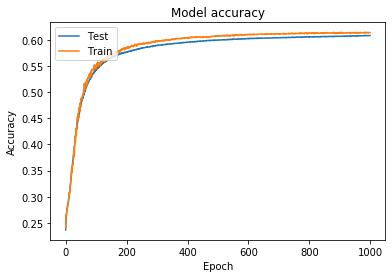

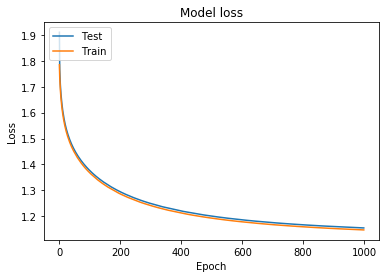

In [79]:
#Plot two graphs 'Accuracy v/s Epoch' and 'Loss v/s Epoch'
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Test', 'Train'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Test', 'Train'], loc='upper left')
plt.show()
